In [10]:
#Import general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Import libraries useful for building the pipeline and join their branches
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin


#import modules created for data preparation phase
import my_utils
import missing_val_imput
import feature_select
import preprocessing
import adhoc_transf

#import libraries for data preparation phase
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler


#import libraries from modelling phase
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

#to save model fit with GridSearchCV and avoid longer waits
import joblib


In [11]:
#15.6.23 The target feature is dealing with death event and time
#Loading the dataset
path_data=r'heart_failure_clinical_records_dataset.csv'

df=pd.read_csv(path_data)
df.head()

#%%Characterizing the data set
target_features=['DEATH_EVENT','time']
numerical_feats=['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium']
nominal_feats=['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
ordinal_feats=[]

len_numerical_feats=len(numerical_feats)
len_nominal_feats=len(nominal_feats)
len_ordinal_feats=len(ordinal_feats)

In [12]:
#%%
###################################################################################################################
#Step 1 Solving wrong characters of dataset
###################################################################################################################
#Set column id as index


# CKD case does only have misspellingCorrector
# df_content_solver=Pipeline([('fx1', misspellingCorrector()),
#                             ('fx2',function2()),
#                             ('fx3',function3())
# ])

#%%
df=adhoc_transf.ageRounder().fit_transform(df)
#my_utils.df_values(df)

#%%Performing numeric cast for numerical features
df.loc[:,numerical_feats]=adhoc_transf.Numeric_Cast_Column().fit_transform(df.loc[:,numerical_feats])
df[numerical_feats].dtypes


#%%Performing category cast for nominal features
df.loc[:,nominal_feats]=adhoc_transf.Category_Cast_Column().fit_transform(df.loc[:,nominal_feats])
df[nominal_feats].dtypes

#%%Performing category cast for ordinal features
df.loc[:,ordinal_feats]=adhoc_transf.Category_Cast_Column().fit_transform(df.loc[:,ordinal_feats])
df[ordinal_feats].dtypes

#%%
###################################################################################################################
##Step 1.1 Winsorization strategies to set the outliers to the values of 10 and 90 percentiles
####################################################################


def winsorize_percentiles(df, columns, lower_percentile, upper_percentile):
    for column in columns:
        lower_limit = df[column].quantile(lower_percentile/100)
        upper_limit = df[column].quantile(upper_percentile/100)
        df[column] = df[column].clip(lower_limit, upper_limit)
    return df

# Example usage

columns_to_winsorize = ['creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium',]
lower_percentile = 0
upper_percentile = 90

df = winsorize_percentiles(df, columns_to_winsorize, lower_percentile, upper_percentile)



>>>>>>>>Calling init() from ageRounder

>>>>>>>>Calling fit() from ageRounder

>>>>>>>>Calling transform() from ageRounder

>>>>>>>>Calling rounder

>>>>>>>>Calling init() from Numeric_Cast_Column

>>>>>>>>Calling fit() from Numeric_Cast_Column

>>>>>>>>Calling transform() from Numeric_Cast_Column

>>>>>>>>Calling init() from Category_Cast_Column

>>>>>>>>Calling fit() from Category_Cast_Column

>>>>>>>>Calling transform() from Category_Cast_Column

>>>>>>>>Calling init() from Category_Cast_Column

>>>>>>>>Calling fit() from Category_Cast_Column

>>>>>>>>Calling transform() from Category_Cast_Column


In [13]:
#%%
#15.6.2023
###################################################################################################################
##Step 2 Train-Test splitting
###################################################################################################################

#Split the dataset into train and test
#The stratificatin is made on the death_event
test_ratio_split=0.3
train_set,test_set=train_test_split(df, test_size=test_ratio_split, random_state=42, stratify=df['DEATH_EVENT'])

X_train=train_set.drop(target_features,axis=1)
y_train=train_set[target_features].copy()

X_test=test_set.drop(target_features,axis=1)
y_test=test_set[target_features].copy()

In [14]:
y_train['DEATH_EVENT']=y_train['DEATH_EVENT'].astype(bool)
y_test['DEATH_EVENT']=y_test['DEATH_EVENT'].astype(bool)

In [15]:
y_train=y_train.to_records(index=False)
y_test=y_test.to_records(index=False)

In [16]:
y_train

rec.array([( True, 172), (False, 230), (False,  87), (False, 121),
           (False, 237), (False,  80), (False,  88), ( True,   8),
           (False, 107), ( True,  10), (False, 209), (False, 205),
           (False, 121), (False, 187), (False,  88), (False,  30),
           (False, 250), (False, 107), ( True,  23), (False, 187),
           ( True,   6), (False, 215), ( True,  10), ( True,  82),
           ( True, 154), (False, 187), (False, 186), (False,  79),
           (False, 109), ( True,  43), ( True,  27), ( True, 111),
           (False,  91), ( True,  55), ( True, 126), (False,  95),
           ( True,  29), (False, 192), ( True,  10), (False,  63),
           ( True,  10), ( True,  67), (False, 175), ( True,  78),
           (False, 209), (False, 172), (False,  94), (False, 213),
           (False,  83), (False, 108), (False,  22), (False, 250),
           ( True, 150), (False, 245), (False, 207), ( True, 129),
           (False, 214), (False, 197), (False, 205), ( True,  

Text(0.5, 0, 'time $t$')

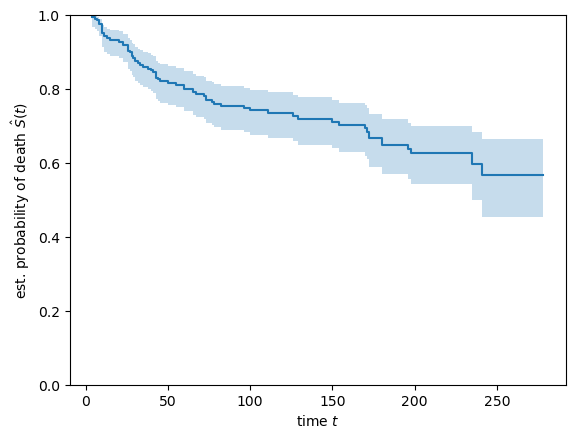

In [17]:
#%%
#Survival analysis with Kaplan_meier
from sksurv.nonparametric import kaplan_meier_estimator


time, survival_prob, conf_int = kaplan_meier_estimator(
    y_train["DEATH_EVENT"],y_train["time"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel("est. probability of death $\hat{S}(t)$")
plt.xlabel("time $t$")

# Applying Multivariate Survival Model with Cox

Following the tutotial:https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html#Survival-Data

In it they apply OneHotEncoder before fitting. We dont apply the OneHotEncoder to our nominal feature becuase they are already coded as 0 or 1


In [18]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators
print(X_train.head())
estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train, y_train)
pd.Series(estimator.coef_, index=X_train.columns)

#Measuring the Performance of Survival Models
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(X_train)
result = concordance_index_censored(y_train["DEATH_EVENT"],y_train["time"], prediction)
result[0]

      age anaemia  creatinine_phosphokinase diabetes  ejection_fraction  \
186  50.0       0                     582.0        0                 50   
258  45.0       1                      66.0        1                 25   
104  60.0       0                      53.0        0                 50   
161  45.0       1                     130.0        0                 35   
263  68.0       1                     157.0        1                 60   

    high_blood_pressure  platelets  serum_creatinine  serum_sodium sex smoking  
186                   0   153000.0               0.6         134.0   0       0  
258                   0   233000.0               0.8         135.0   1       0  
104                   1   286000.0               2.1         141.2   0       0  
161                   0   174000.0               0.8         139.0   1       1  
263                   0   208000.0               1.0         140.0   0       0  


0.7438000390548721

In [10]:
#Using the MinMax scaler, in theory using cox is not needed to Scaling the numerical value
set_config(display="text")  # displays text representation of estimators
X_train[numerical_feats]=MinMaxScaler().fit_transform(X_train[numerical_feats])
print(X_train.head())
estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train, y_train)
series=pd.Series(estimator.coef_, index=X_train.columns)
print('Log hazard ratio with MinMaxScaler:\n', series )

#Measuring the Performance of Survival Models
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(X_train)
result = concordance_index_censored(y_train["DEATH_EVENT"],y_train["time"], prediction)
result[0]


          age anaemia  creatinine_phosphokinase diabetes  ejection_fraction  \
186  0.181818       0                  0.473408        0           0.777778   
258  0.090909       1                  0.036416        1           0.222222   
104  0.363636       0                  0.025407        0           0.777778   
161  0.090909       1                  0.090617        0           0.444444   
263  0.509091       1                  0.113482        1           1.000000   

    high_blood_pressure  platelets  serum_creatinine  serum_sodium sex smoking  
186                   0   0.365951            0.0625      0.714286   0       0  
258                   0   0.594850            0.1875      0.753968   1       0  
104                   1   0.746495            1.0000      1.000000   0       0  
161                   0   0.426037            0.1875      0.912698   1       1  
263                   0   0.523319            0.3125      0.952381   0       0  
Log hazard ratio with MinMaxScaler:
 ag

0.7438000390548721

In [19]:
#Using the StandarScaler, in theory using cox is not needed to Scaling the numerical value
# set_config(display="text")  # displays text representation of estimators
# X_train[numerical_feats]=StandardScaler().fit_transform(X_train[numerical_feats])
# print(X_train.head())
# estimator = CoxPHSurvivalAnalysis()
# estimator.fit(X_train, y_train)
# series=pd.Series(estimator.coef_, index=X_train.columns)
# print('Log hazard ratio with StandardScaler:\n', series )

# #Measuring the Performance of Survival Models
# from sksurv.metrics import concordance_index_censored

# prediction = estimator.predict(X_train)
# result = concordance_index_censored(y_train["DEATH_EVENT"],y_train["time"], prediction)
# result[0]

In [ ]:
##FIXME the results below are calculated with StandardScaler

In [20]:
#Measuring the Performance of Survival Models
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(X_train)
result = concordance_index_censored(y_train["DEATH_EVENT"],y_train["time"], prediction)
result[0]

0.7438000390548721

In [21]:
#Feature Selection: Which Variable is Most Predictive?
import numpy as np


def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores


scores = fit_and_score_features(X_train.values, y_train)
pd.Series(scores, index=X_train.columns).sort_values(ascending=False)

serum_creatinine            0.679408
ejection_fraction           0.623169
age                         0.585140
serum_sodium                0.580258
high_blood_pressure         0.559217
anaemia                     0.540617
smoking                     0.521334
sex                         0.516550
creatinine_phosphokinase    0.515183
diabetes                    0.507665
platelets                   0.495167
dtype: float64

In [22]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    [
        ("select", SelectKBest(fit_and_score_features, k=3)),
        ("model", CoxPHSurvivalAnalysis()),
    ]
)

from sklearn.model_selection import GridSearchCV, KFold

param_grid = {"select__k": np.arange(1, X_train.shape[1] + 1)}
cv = KFold(n_splits=5, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(X_train, y_train)

results = pd.DataFrame(gcv.cv_results_).sort_values(by="mean_test_score", ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
4,5,{'select__k': 5},0.652352,0.700000,0.692308,0.724512,0.766197,0.707074,0.037583,1,0.729607,0.735265,0.741971,0.729190,0.715951,0.730397,0.008584
9,10,{'select__k': 10},0.662577,0.729167,0.645299,0.715835,0.757746,0.702125,0.041967,2,0.762236,0.744505,0.757475,0.735215,0.728789,0.745644,0.012723
8,9,{'select__k': 9},0.631902,0.725000,0.653846,0.722343,0.771831,0.700984,0.051081,3,0.761428,0.736385,0.753362,0.738703,0.726575,0.743291,0.012478
5,6,{'select__k': 6},0.617587,0.712500,0.692308,0.746204,0.732394,0.700199,0.045147,4,0.741560,0.736665,0.744502,0.730775,0.719788,0.734658,0.008773
7,8,{'select__k': 8},0.631902,0.695833,0.651709,0.752711,0.763380,0.699107,0.052494,5,0.760297,0.733305,0.748141,0.733946,0.725542,0.740246,0.012397
10,11,{'select__k': 11},0.660532,0.733333,0.638889,0.715835,0.743662,0.698450,0.041349,6,0.762236,0.744225,0.761430,0.745521,0.727313,0.748145,0.012894
2,3,{'select__k': 3},0.652352,0.697917,0.654915,0.760304,0.704225,0.693942,0.039442,7,0.715232,0.709856,0.726309,0.702236,0.708130,0.712353,0.008118
3,4,{'select__k': 4},0.666667,0.695833,0.662393,0.728850,0.712676,0.693284,0.025730,8,0.722177,0.707966,0.725518,0.727763,0.706655,0.718016,0.008930
6,7,{'select__k': 7},0.619632,0.708333,0.658120,0.748373,0.721127,0.691117,0.046204,9,0.742691,0.737225,0.751622,0.732044,0.722148,0.737146,0.009912
1,2,{'select__k': 2},0.666667,0.679167,0.677350,0.662690,0.728169,0.682809,0.023520,10,0.710548,0.701526,0.717371,0.693277,0.694703,0.703485,0.009250


In [23]:
pipe.set_params(**gcv.best_params_)
pipe.fit(X_train, y_train)

transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=X_train.columns[transformer.get_support()])

age                    0.023882
ejection_fraction     -0.035006
high_blood_pressure    0.602798
serum_creatinine       1.151325
serum_sodium          -0.025107
dtype: float64

In [24]:
print('************transformer************:',transformer)
print('************final_estimator************:',final_estimator)


************transformer************: SelectKBest(k=5,
            score_func=<function fit_and_score_features at 0x000002DAE84DC5E0>)
************final_estimator************: CoxPHSurvivalAnalysis()


# Evaluating the former survival model

Following the tutotial:https://scikit-survival.readthedocs.io/en/stable/user_guide/evaluating-survival-models.html

In [25]:
# The tutorial recommends to use concordance_index_ipcw
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

In [26]:
#to evaluate the ROC at, due to the estimator’s dependence on inverse probability of censoring weighting. First, we are going to check whether the observed time of the test data lies within the observed time range of the training data
y_events = y_train[y_train["DEATH_EVENT"]]
train_min, train_max = y_events["time"].min(), y_events["time"].max()

y_events = y_test[y_test["DEATH_EVENT"]]
test_min, test_max = y_events["time"].min(), y_events["time"].max()

assert (
    train_min <= test_min < test_max < train_max
), "time range or test data is not within time range of training data."

In [27]:
times = np.percentile(y_train["time"], np.linspace(5, 95, 15))
print(times)

[ 11.          28.          43.          67.51428571  79.
  87.          98.51428571 111.         134.94285714 172.
 187.         205.         211.85714286 231.45714286 246.        ]


In [29]:
def plot_cumulative_dynamic_auc(risk_score, label, color=None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)

    plt.plot(times, auc, marker="o", color=color, label=label)
    plt.xlabel("days from enrollment")
    plt.ylabel("time-dependent AUC")
    plt.axhline(mean_auc, color=color, linestyle="--")
    plt.legend()

x_test_imputed=X_test.loc[:,numerical_feats]

for i, col in enumerate(numerical_feats):
    plot_cumulative_dynamic_auc(x_test_imputed[:, i], col, color=f"C{i}")
    ret = concordance_index_ipcw(y_train, y_test, x_test_imputed[:, i], tau=times[-1])

InvalidIndexError: (slice(None, None, None), 0)

In [30]:
y_test['time'].min()

7

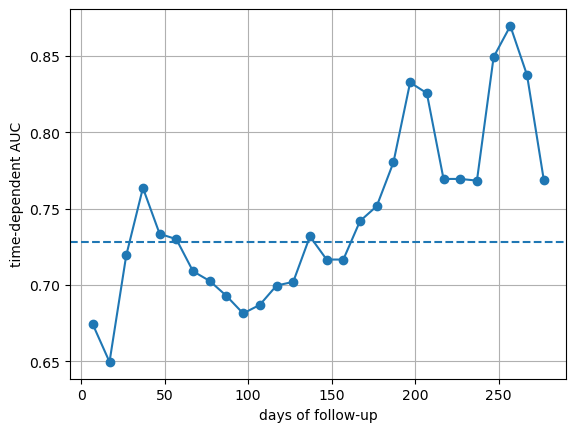

In [31]:
#Evaluate a Model's prediction by using the cumulative dynamic auc

from sksurv.linear_model import CoxPHSurvivalAnalysis
cox_ph=CoxPHSurvivalAnalysis()
cox_ph.fit(X_train,y_train)

hf_times=np.arange(7, 285, 10)

cox_ph_risk_scores=cox_ph.predict(X_test)
cox_ph_auc, cox_ph_mean_auc = cumulative_dynamic_auc(y_train, y_test, cox_ph_risk_scores, hf_times)

plt.plot(hf_times, cox_ph_auc, marker="o")
plt.axhline(cox_ph_mean_auc, linestyle="--")
plt.xlabel("days of follow-up")
plt.ylabel("time-dependent AUC")
plt.grid(True)

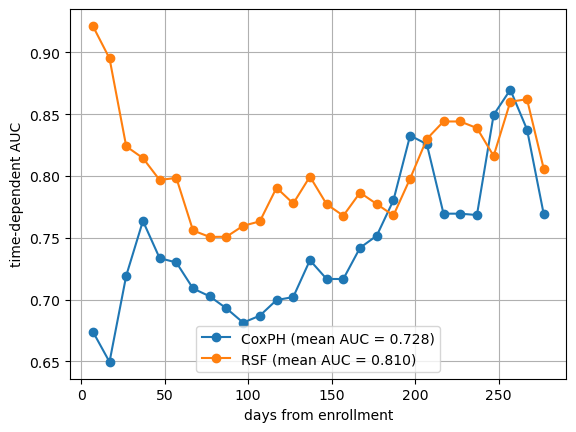

In [32]:
#Using Time-dependent Risk Scores
from sksurv.ensemble import RandomSurvivalForest

rsf = RandomSurvivalForest(n_estimators=100, min_samples_leaf=7, random_state=0)
rsf.fit(X_train, y_train)

rsf_chf_funcs = rsf.predict_cumulative_hazard_function(X_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(hf_times) for chf in rsf_chf_funcs])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train, y_test, rsf_risk_scores, hf_times)

plt.plot(hf_times, cox_ph_auc, "o-", label=f"CoxPH (mean AUC = {cox_ph_mean_auc:.3f})")
plt.plot(hf_times, rsf_auc, "o-", label=f"RSF (mean AUC = {rsf_mean_auc:.3f})")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)

In [33]:
#time-dependent brier score
score_cindex = pd.Series(
    [
        rsf.score(X_test, y_test),
        cox_ph.score(X_test, y_test),
        0.5,
    ],
    index=["RSF", "CPH", "Random"],
    name="c-index",
)

score_cindex.round(3)

RSF       0.770
CPH       0.707
Random    0.500
Name: c-index, dtype: float64

In [34]:
from sksurv.functions import StepFunction

rsf_surv_prob = np.row_stack([fn(hf_times) for fn in rsf.predict_survival_function(X_test)])
cph_surv_prob = np.row_stack([fn(hf_times) for fn in cox_ph.predict_survival_function(X_test)])

random_surv_prob = 0.5 * np.ones((y_test.shape[0], hf_times.shape[0]))

km_func = StepFunction(*kaplan_meier_estimator(y_test["DEATH_EVENT"], y_test["time"]))
km_surv_prob = np.tile(km_func(hf_times), (y_test.shape[0], 1))

score_brier = pd.Series(
    [
        integrated_brier_score(y_train, y_test, h, hf_times)
        for prob in (rsf_surv_prob, cph_surv_prob, random_surv_prob, km_surv_prob)
    ],
    index=["RSF", "CPH", "Random", "Kaplan-Meier"],
    name="IBS",
)

pd.concat((score_cindex, score_brier), axis=1).round(3)

NameError: name 'h' is not defined

In [35]:
# Using Metrics in Hyper-parameter Search using GridSearchCV
from sklearn.model_selection import GridSearchCV, KFold

from sksurv.metrics import (
    as_concordance_index_ipcw_scorer,
    as_cumulative_dynamic_auc_scorer,
    as_integrated_brier_score_scorer,
)

# Penalized Cox Models
tutorial from https://scikit-survival.readthedocs.io/en/stable/user_guide/coxnet.html

In [37]:
#Ridge penalization
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis

cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(X_train, y_train)


CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9)

In [38]:
#Choosing penaly strength alpha

import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio='auto', max_iter=100))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(l1_ratio=0.9, max_iter=100))])

In [39]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(X_train, y_train)

cv_results = pd.DataFrame(gcv.cv_results_)

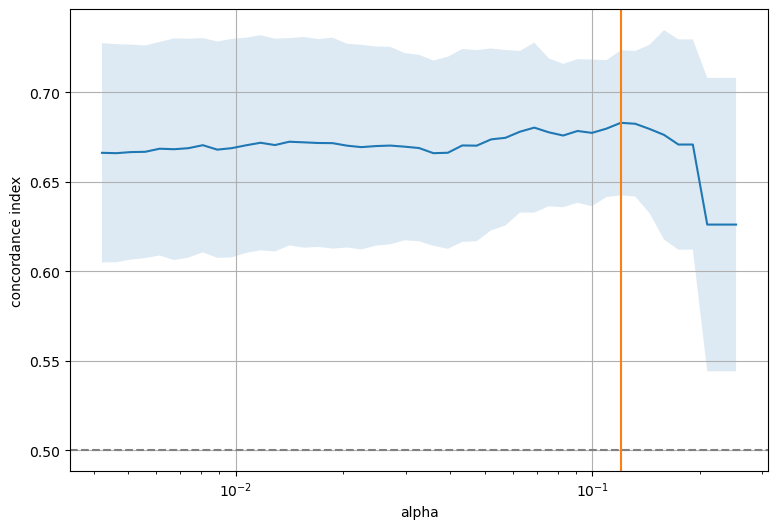

In [40]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

Number of non-zero coefficients: 2


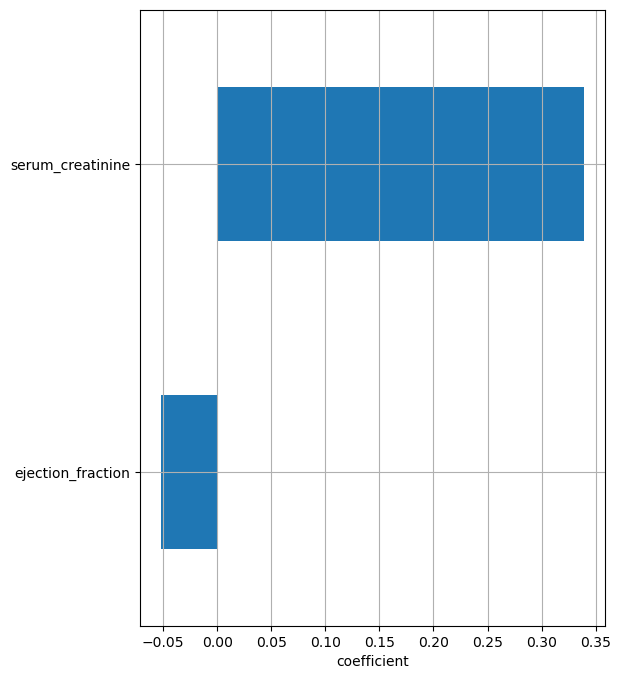

In [41]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=X_train.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [42]:
coxnet_pred = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True))
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.12027832732354682],
                                        fit_baseline_model=True,
                                        l1_ratio=0.9))])

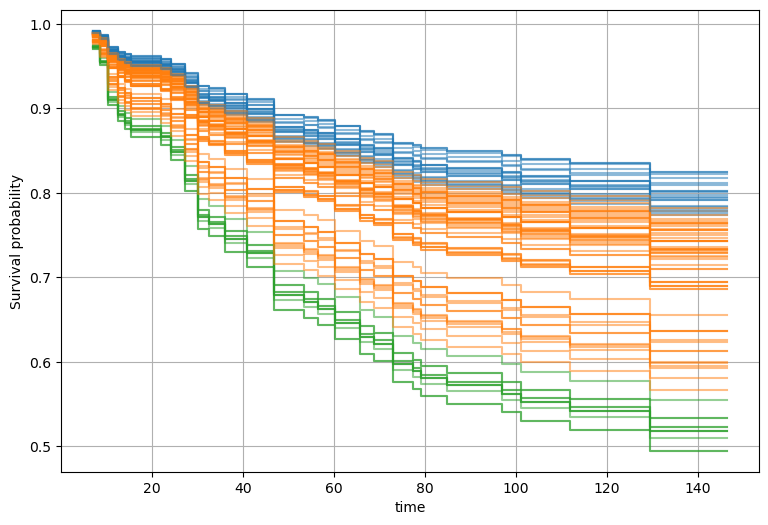

In [43]:
surv_fns = coxnet_pred.predict_survival_function(X_test)
time_points = np.quantile(y_test["time"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(surv_fns, X_test.loc[:, "serum_creatinine"].astype(int)):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.5)
    
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)
#We dont know what this code is doing

# Using Random Survival Forests
Got from the tutorial https://scikit-survival.readthedocs.io/en/stable/user_guide/random-survival-forest.html

Note: here the plot are a bit counter intuitive since the examples are trying to predict the survival and not the death event, i.e. the y column that handles the event is 'cens' instead of 'death'

In [44]:
from sksurv.ensemble import RandomSurvivalForest
#y_train['DEATH_EVENT']=~y_train['DEATH_EVENT']
random_state=20
rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=random_state)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=20)

In [62]:
rsf.score(X_train, y_train)

0.7932044522554189

In [45]:
#y_test['DEATH_EVENT']=~y_test['DEATH_EVENT']

rsf.score(X_test, y_test)

0.7423014586709886

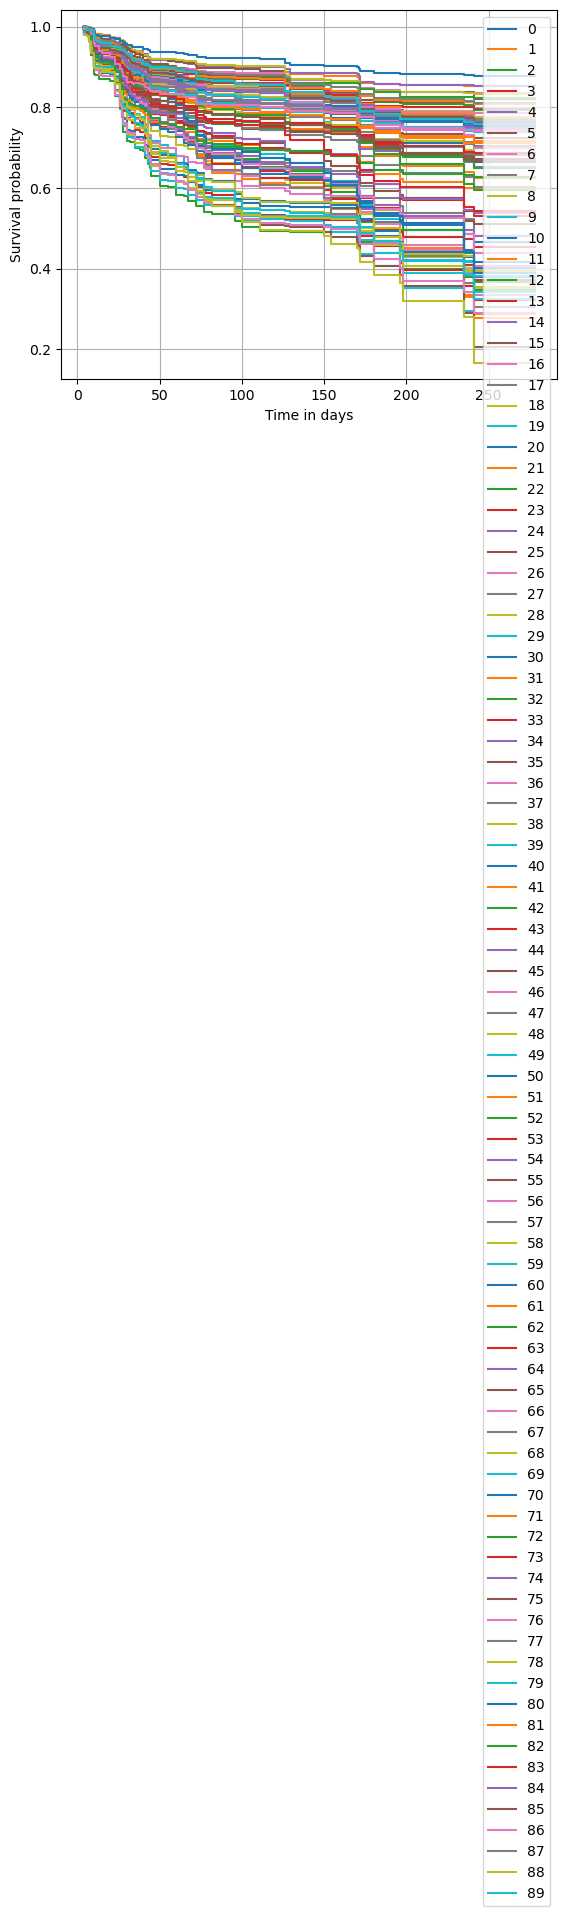

In [46]:
surv = rsf.predict_survival_function(X_test, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

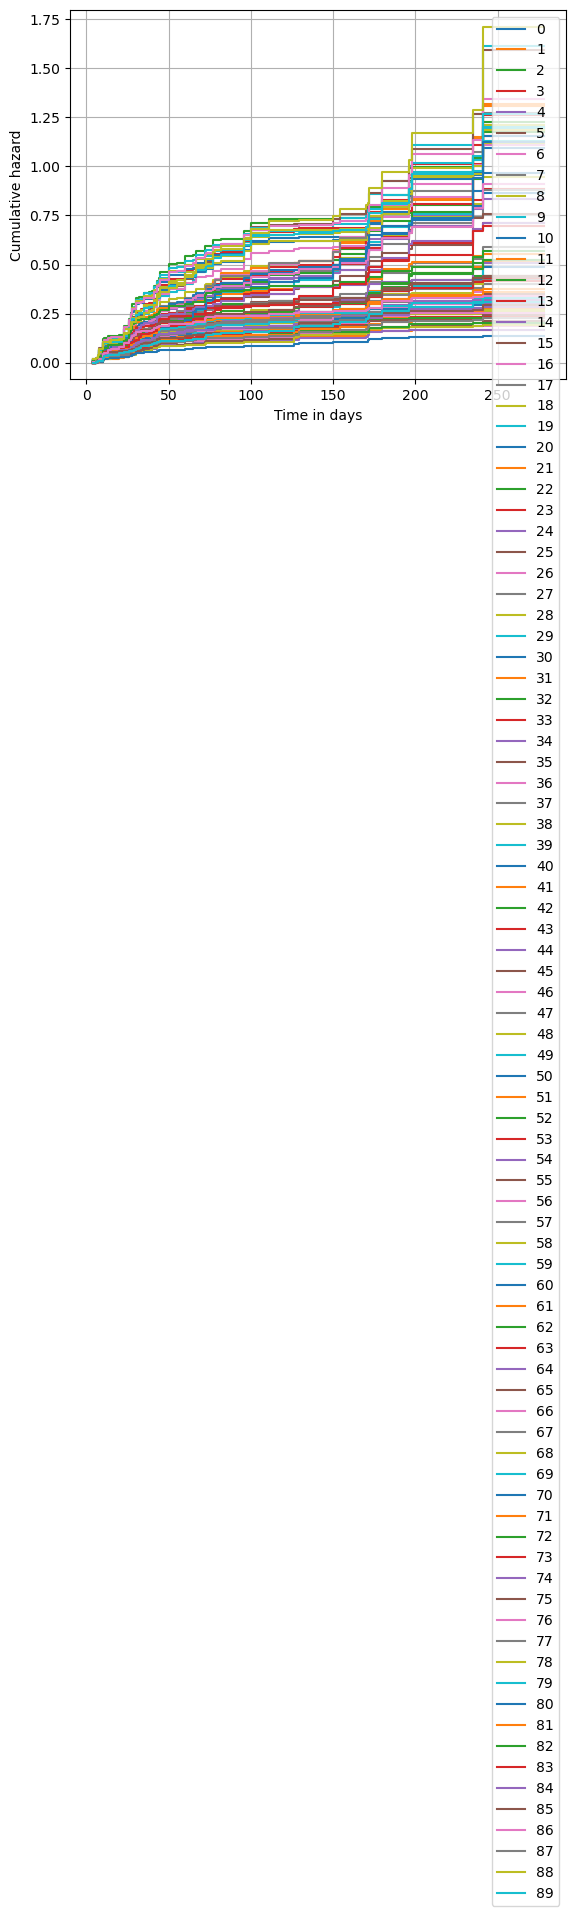

In [47]:
surv = rsf.predict_cumulative_hazard_function(X_test, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

In [48]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_test, y_test, n_repeats=15, random_state=random_state)
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
serum_creatinine,0.086440,0.024802
age,0.065262,0.007757
ejection_fraction,0.057951,0.027918
serum_sodium,0.013398,0.008229
anaemia,0.006087,0.004126
platelets,0.003746,0.003274
creatinine_phosphokinase,0.003350,0.002770
smoking,0.002233,0.002068
high_blood_pressure,0.002089,0.005391
sex,0.000720,0.000702


# Gradient Boosted Models
From the tutorial in https://scikit-survival.readthedocs.io/en/stable/user_guide/boosting.html


In [49]:
# it is recommended to use the GradientBoostingSurvivalAnalysis
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
est_cph_tree.fit(X_train, y_train)
cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 3))

0.776


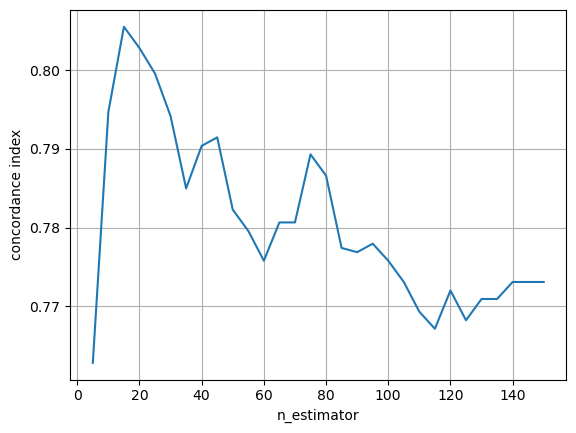

In [50]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0)
for i in range(1, 31):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

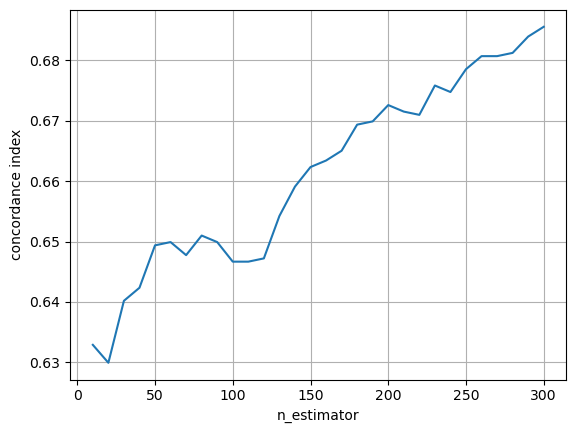

In [51]:
scores_cph_ls = {}

est_cph_ls = ComponentwiseGradientBoostingSurvivalAnalysis(learning_rate=1.0, random_state=0)
for i in range(1, 31):
    n_estimators = i * 10
    est_cph_ls.set_params(n_estimators=n_estimators)
    est_cph_ls.fit(X_train, y_train)
    scores_cph_ls[n_estimators] = est_cph_ls.score(X_test, y_test)

x, y = zip(*scores_cph_ls.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [52]:
coef = pd.Series(est_cph_ls.coef_, ["Intercept"] + X_train.columns.tolist())

print("Number of non-zero coefficients:", (coef != 0).sum())
coef_nz = coef[coef != 0]
coef_order = coef_nz.abs().sort_values(ascending=False).index
coef_nz.loc[coef_order]

Number of non-zero coefficients: 8


serum_creatinine            1.366750
high_blood_pressure         0.578519
anaemia                     0.466919
diabetes                    0.337769
smoking                     0.287214
ejection_fraction          -0.027397
age                         0.014383
creatinine_phosphokinase    0.000122
dtype: float64

In [53]:
est_aft_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    loss="ipcwls", n_estimators=300, learning_rate=1.0, random_state=0
).fit(X_train, y_train)
cindex = est_aft_ls.score(X_test, y_test)
print(round(cindex, 3))

0.686


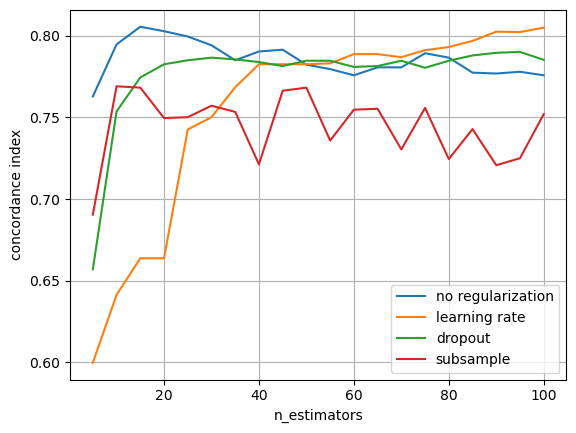

In [54]:
n_estimators = [i * 5 for i in range(1, 21)]

estimators = {
    "no regularization": GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0),
    "learning rate": GradientBoostingSurvivalAnalysis(learning_rate=0.1, max_depth=1, random_state=0),
    "dropout": GradientBoostingSurvivalAnalysis(learning_rate=1.0, dropout_rate=0.1, max_depth=1, random_state=0),
    "subsample": GradientBoostingSurvivalAnalysis(learning_rate=1.0, subsample=0.5, max_depth=1, random_state=0),
}

scores_reg = {k: [] for k in estimators.keys()}
for n in n_estimators:
    for name, est in estimators.items():
        est.set_params(n_estimators=n)
        est.fit(X_train, y_train)
        cindex = est.score(X_test, y_test)
        scores_reg[name].append(cindex)

scores_reg = pd.DataFrame(scores_reg, index=n_estimators)

ax = scores_reg.plot(xlabel="n_estimators", ylabel="concordance index")
ax.grid(True)

# Introduction to Survival Support Vector Machine
From guide: https://scikit-survival.readthedocs.io/en/stable/user_guide/survival-svm.html

In [55]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
from sklearn import set_config
from sklearn.model_selection import ShuffleSplit, GridSearchCV

from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

set_config(display="text")  # displays text representation of estimators
sns.set_style("whitegrid")

In [56]:
#%%
###################################################################################################################
##Step 4 Building pipelines for data preparation
###################################################################################################################

#Lets define 3 pipeline mode
#a) parallel approach where feature selection is performed in parallel 
# for numerical, nominal and categorical
#b) general approach where feature selection is performed as a whole for other features
#c) no feature selection is performed

#Before a data preprocessing will take place for each type of feature
pipeline_numeric_feat=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='median')),
                                 ('scaler', MinMaxScaler())])

pipeline_numeric_feat_mean=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='mean')),
                                 ('scaler', MinMaxScaler())])

pipeline_nominal_feat=Pipeline([('data_missing',missing_val_imput.Category_Imputer()),                                 
                                 ('encoding', OrdinalEncoder())])#We dont use OneHotEncoder since it enlarges the number of nominal features 

pipeline_ordinal_feat=Pipeline([ ('data_missing',missing_val_imput.Category_Imputer(strategy='most_frequent')),
                                 ('encoding', OrdinalEncoder())])


#option a)
pipe_numeric_featsel=Pipeline([('data_prep',pipeline_numeric_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])
pipe_nominal_featsel=Pipeline([('data_prep',pipeline_nominal_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])
pipe_ordinal_featsel=Pipeline([('data_prep',pipeline_ordinal_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])

dataprep_pipe_opta=ColumnTransformer([('numeric_pipe',pipe_numeric_featsel,numerical_feats),
                                    ('nominal_pipe',pipe_nominal_featsel,nominal_feats),
                                    ('ordinal_pipe',pipe_ordinal_featsel,ordinal_feats)
                                ])

#option c)
dataprep_merge_feat=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat,numerical_feats),
                                    ('nominal_pipe',pipeline_nominal_feat, nominal_feats),
                                    ('ordinal_pipe',pipeline_ordinal_feat,ordinal_feats)
                                ])


 Fri Jun 30 10:33:27 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Fri Jun 30 10:33:27 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Fri Jun 30 10:33:27 2023 >>>>>>>>Calling init() from Category_Imputer

 Fri Jun 30 10:33:27 2023 >>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector


In [57]:
#Init the estimator here
cox=CoxPHSurvivalAnalysis()
# survRF=
# survGB=
# survSVM=FastSurvivalSVM

In [58]:
###################################################################################################################
##Step 7 Training the data set with GridSearchCV
###################################################################################################################


##7.a.1 Parallel approach
###################################################################################################################
full_parallel_pipe_opta=Pipeline([('data_prep',dataprep_pipe_opta),('est',cox)])
full_parallel_pipe_opta.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'data_prep', 'est', 'data_prep__n_jobs', 'data_prep__remainder', 'data_prep__sparse_threshold', 'data_prep__transformer_weights', 'data_prep__transformers', 'data_prep__verbose', 'data_prep__verbose_feature_names_out', 'data_prep__numeric_pipe', 'data_prep__nominal_pipe', 'data_prep__ordinal_pipe', 'data_prep__numeric_pipe__memory', 'data_prep__numeric_pipe__steps', 'data_prep__numeric_pipe__verbose', 'data_prep__numeric_pipe__data_prep', 'data_prep__numeric_pipe__feat_sel', 'data_prep__numeric_pipe__data_prep__memory', 'data_prep__numeric_pipe__data_prep__steps', 'data_prep__numeric_pipe__data_prep__verbose', 'data_prep__numeric_pipe__data_prep__data_missing', 'data_prep__numeric_pipe__data_prep__scaler', 'data_prep__numeric_pipe__data_prep__data_missing__strategy', 'data_prep__numeric_pipe__data_prep__scaler__clip', 'data_prep__numeric_pipe__data_prep__scaler__copy', 'data_prep__numeric_pipe__data_prep__scaler__feature_range', 'data_prep__nume

In [59]:
# This is not valid 
scoring = {
    'c_index_censored': make_scorer(concordance_index_censored()),
    'c_index_ipcw': make_scorer(concordance_index_ipcw),
    'cd_auc': make_scorer(cumulative_dynamic_auc),
    'brier_score': make_scorer(integrated_brier_score),
    }

TypeError: concordance_index_censored() missing 3 required positional arguments: 'event_indicator', 'event_time', and 'estimate'

In [ ]:
#Example to see the an individual fitting
cox=CoxPHSurvivalAnalysis()
full_parallel_pipe_opta=Pipeline([('data_prep',dataprep_pipe_opta),('clf',cox)])
cox.fit(X_train,y_train)

In [ ]:
#it is needed to create different GridSearcCV for each of the metric considered



gcv_cindex = GridSearchCV(
    as_concordance_index_ipcw_scorer(cox, tau=y_train_time[-1]),
    param_grid=cv_param_grid,
    cv=cv,
    n_jobs=4,
).fit(gbsg_X, gbsg_y)

In [ ]:
###################################################################################################################
#Step 8: Application of SCI-XAI per each type of survival analysis estimator
###################################################################################################################

#vcox_Cindex: Cox's proportional hazards model and concordance index ipcw as scorer
cox=CoxPHSurvivalAnalysis()
y_train_time=y_train['time']
full_parallel_pipe_opta=Pipeline([('data_prep',dataprep_pipe_opta),('clf',cox)])
##########################################################################################################################################
#%%
param_grid_vcox_Cindex_exp={
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['mean','median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
                    }

clf_vcox_exp_Cindex=GridSearchCV(as_concordance_index_ipcw_scorer(cox, tau=y_train_time[-1]),param_grid_vcox_Cindex_exp, cv=5,n_jobs=None)
clf_vcox_exp_Cindex.fit(X_train,y_train)
#%%
print('Score of best estimator of clf_vDT_exp:', clf_vcox_exp.best_score_) #Score of best estimator of clf_vcox:0.8063281546040166

#%%
#Saving the results in an excel
df_results_vDT_exp=pd.DataFrame(clf_vcox_exp.cv_results_)
df_results_vDT_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization_SurvAnalysis/df_results_vcox_exp.xlsx',index=False)
#Saving the model
joblib.dump(clf_vcox_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization_SurvAnalysis/clf_vcox_exp.pkl', compress=1)



In [ ]:
#%%
#Obtaining restuls with the test set
clf_vcox_exp.refit
y_pred_vDT_exp = clf_vcox_exp.predict(X_test)

test_results_DT={'clf':['clf_vDT_exp'],
                 'params':[clf_vcox_exp.best_params_],
                 'cindex_censored_test':[concordance_index_censored(y_test, y_pred_vDT_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vDT_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vDT_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vDT_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vDT_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vDT_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vDT_exp)]    
    }
#%%
test_results_DT_paper=pd.DataFrame(data=test_results_DT)
test_results_DT_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/test_results_DT_paper.xlsx',index=False)

In [ ]:
###################################################################################################################
#Step 8_notime: Application of SCI-XAI per each type of classifier
###################################################################################################################

#vDT:DecisionTree_notime
##########################################################################################################################################
#%%
param_grid_vDT_exp={'clf':[dectree_clf],
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['mean','median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
                    }

clf_vDT_exp=GridSearchCV(full_parallel_pipe_opta_notime,param_grid_vDT_exp,scoring=scoring,refit='balanced_accuracy', cv=5,n_jobs=None)
clf_vDT_exp.fit(X_train_notime,y_train)
#%%
print('Score of best estimator of clf_vDT_exp:', clf_vDT_exp.best_score_) #Score of best estimator of clf_vDT:0.8063281546040166

#%%
#Saving the results in an excel
df_results_vDT_exp=pd.DataFrame(clf_vDT_exp.cv_results_)
df_results_vDT_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/df_results_vDT_exp_notime.xlsx',index=False)
#Saving the model
joblib.dump(clf_vDT_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization/clf_vDT_exp_notime.pkl', compress=1)

#%%
#Obtaining classification  with test set
clf_vDT_exp.refit
y_pred_vDT_exp = clf_vDT_exp.predict(X_test_notime)

test_results_DT={'clf':['clf_vDT_exp'],
                 'params':[clf_vDT_exp.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_vDT_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vDT_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vDT_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vDT_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vDT_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vDT_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vDT_exp)]    
    }
#%%
test_results_DT_paper=pd.DataFrame(data=test_results_DT)
test_results_DT_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/test_results_DT_paper_notime.xlsx',index=False)


In [ ]:
#vRF:Random Forest
###################################################################################################################
#%%
param_grid_vRF_exp={'clf': [rndforest_clf],
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
     }

clf_vRF_exp=GridSearchCV(full_parallel_pipe_opta,param_grid_vRF_exp,scoring=scoring,refit='balanced_accuracy', cv=5,n_jobs=None)
clf_vRF_exp.fit(X_train,y_train)
#%%
print('Score of best estimator of clf_vRF_exp:', clf_vRF_exp.best_score_) #Score of best estimator of clf_vRF: 1

#Saving the results in an excel
df_results_vRF_exp=pd.DataFrame(clf_vRF_exp.cv_results_)
df_results_vRF_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/df_results_vRF_exp.xlsx',index=False)
#Saving the model
joblib.dump(clf_vRF_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization/clf_vRF_exp.pkl', compress=1)

#%%
#Obtaining classification  with test set
clf_vRF_exp.refit
y_pred_vRF_exp = clf_vRF_exp.predict(X_test)

test_results_RF={'clf':['clf_vRF_exp'],
                 'params':[clf_vRF_exp.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_vRF_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vRF_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vRF_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vRF_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vRF_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vRF_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vRF_exp)]    
    }
#%%
test_results_RF_paper=pd.DataFrame(data=test_results_RF)
test_results_RF_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/test_results_RF_paper.xlsx',index=False)


In [ ]:
#vRF:Random Forest_notime
###################################################################################################################
#%%
param_grid_vRF_exp={'clf': [rndforest_clf],
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
     }

clf_vRF_exp=GridSearchCV(full_parallel_pipe_opta_notime,param_grid_vRF_exp,scoring=scoring,refit='balanced_accuracy', cv=5,n_jobs=None)
clf_vRF_exp.fit(X_train_notime,y_train)
#%%
print('Score of best estimator of clf_vRF_exp:', clf_vRF_exp.best_score_) #Score of best estimator of clf_vRF: 1

#Saving the results in an excel
df_results_vRF_exp=pd.DataFrame(clf_vRF_exp.cv_results_)
df_results_vRF_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/df_results_vRF_exp_notime.xlsx',index=False)
#Saving the model
joblib.dump(clf_vRF_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization/clf_vRF_exp_notime.pkl', compress=1)

#%%
#Obtaining classification  with test set
clf_vRF_exp.refit
y_pred_vRF_exp = clf_vRF_exp.predict(X_test_notime)

test_results_RF={'clf':['clf_vRF_exp'],
                 'params':[clf_vRF_exp.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_vRF_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vRF_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vRF_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vRF_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vRF_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vRF_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vRF_exp)]    
    }
#%%
test_results_RF_paper=pd.DataFrame(data=test_results_RF)
test_results_RF_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/test_results_RF_paper_notime.xlsx',index=False)

In [ ]:
#%%
#vET:Extra Trees
###################################################################################################################
#%%
param_grid_vET_exp={'clf':[extratree_clf],
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['mean','median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
                    }

clf_vET_exp=GridSearchCV(full_parallel_pipe_opta,param_grid_vET_exp,scoring=scoring,refit='balanced_accuracy', cv=5,n_jobs=None)
clf_vET_exp.fit(X_train,y_train)
#%%
print('Score of best estimator of clf_vET_exp:', clf_vET_exp.best_score_) #Score of best estimator of clf_vET:0.7623721106479727

#%%
#Saving the results in an excel
df_results_vET_exp=pd.DataFrame(clf_vET_exp.cv_results_)
df_results_vET_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/df_results_vET_exp.xlsx',index=False)
#Saving the model
joblib.dump(clf_vET_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization/clf_vET_exp.pkl', compress=1)

#%%
#Obtaining classification  with test set
clf_vET_exp.refit
y_pred_vET_exp = clf_vET_exp.predict(X_test)

test_results_ET={'clf':['clf_vET_exp'],
                 'params':[clf_vET_exp.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_vET_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vET_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vET_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vET_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vET_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vET_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vET_exp)]    
    }
#%%
test_results_ET_paper=pd.DataFrame(data=test_results_ET)
test_results_ET_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/test_results_ET_paper.xlsx',index=False)



In [ ]:
#%%
#vET:Extra Trees_notime
###################################################################################################################
#%%
param_grid_vET_exp={'clf':[extratree_clf],
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['mean','median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
                    }

clf_vET_exp=GridSearchCV(full_parallel_pipe_opta_notime,param_grid_vET_exp,scoring=scoring,refit='balanced_accuracy', cv=5,n_jobs=None)
clf_vET_exp.fit(X_train_notime,y_train)
#%%
print('Score of best estimator of clf_vET_exp:', clf_vET_exp.best_score_) #Score of best estimator of clf_vET:0.7623721106479727

#%%
#Saving the results in an excel
df_results_vET_exp=pd.DataFrame(clf_vET_exp.cv_results_)
df_results_vET_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/df_results_vET_exp_notime.xlsx',index=False)
#Saving the model
joblib.dump(clf_vET_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization/clf_vET_exp_notime.pkl', compress=1)

#%%
#Obtaining classification  with test set
clf_vET_exp.refit
y_pred_vET_exp = clf_vET_exp.predict(X_test_notime)

test_results_ET={'clf':['clf_vET_exp'],
                 'params':[clf_vET_exp.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_vET_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vET_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vET_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vET_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vET_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vET_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vET_exp)]    
    }
#%%
test_results_ET_paper=pd.DataFrame(data=test_results_ET)
test_results_ET_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/test_results_ET_paper_notime.xlsx',index=False)


In [ ]:
#%%
#vAB:AdaBoost
###################################################################################################################
#%%
param_grid_vAB_exp={'clf':[ada_clf],
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['mean','median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
                    }

clf_vAB_exp=GridSearchCV(full_parallel_pipe_opta,param_grid_vAB_exp,scoring=scoring,refit='balanced_accuracy', cv=5,n_jobs=None)
clf_vAB_exp.fit(X_train,y_train)
#%%
print('Score of best estimator of clf_vAB_exp:', clf_vAB_exp.best_score_) #Score of best estimator of clf_vAB:0.7623721106479727

#%%
#Saving the results in an excel
df_results_vAB_exp=pd.DataFrame(clf_vAB_exp.cv_results_)
df_results_vAB_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/df_results_vAB_exp.xlsx',index=False)
#Saving the model
joblib.dump(clf_vAB_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization/clf_vAB_exp.pkl', compress=1)

#%%
#Obtaining classification  with test set
clf_vAB_exp.refit
y_pred_vAB_exp = clf_vAB_exp.predict(X_test)

test_results_AB={'clf':['clf_vAB_exp'],
                 'params':[clf_vAB_exp.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_vAB_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vAB_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vAB_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vAB_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vAB_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vAB_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vAB_exp)]    
    }
#%%
test_results_AB_paper=pd.DataFrame(data=test_results_AB)
test_results_AB_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/test_results_AB_paper.xlsx',index=False)


In [ ]:
#%%
#vAB:AdaBoost_notime
###################################################################################################################
#%%
param_grid_vAB_exp={'clf':[ada_clf],
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['mean','median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
                    }

clf_vAB_exp=GridSearchCV(full_parallel_pipe_opta_notime,param_grid_vAB_exp,scoring=scoring,refit='balanced_accuracy', cv=5,n_jobs=None)
clf_vAB_exp.fit(X_train_notime,y_train)
#%%
print('Score of best estimator of clf_vAB_exp:', clf_vAB_exp.best_score_) #Score of best estimator of clf_vAB:0.7623721106479727

#%%
#Saving the results in an excel
df_results_vAB_exp=pd.DataFrame(clf_vAB_exp.cv_results_)
df_results_vAB_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/df_results_vAB_exp_notime.xlsx',index=False)
#Saving the model
joblib.dump(clf_vAB_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization/clf_vAB_exp_notime.pkl', compress=1)

#%%
#Obtaining classification  with test set
clf_vAB_exp.refit
y_pred_vAB_exp = clf_vAB_exp.predict(X_test_notime)

test_results_AB={'clf':['clf_vAB_exp'],
                 'params':[clf_vAB_exp.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_vAB_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vAB_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vAB_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vAB_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vAB_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vAB_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vAB_exp)]    
    }
#%%
test_results_AB_paper=pd.DataFrame(data=test_results_AB)
test_results_AB_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/test_results_AB_paper_notime.xlsx',index=False)

In [ ]:
#%%
#vGB:Gradient Boosting
###################################################################################################################
#%%
param_grid_vGB_exp={'clf':[gradboost_clf],
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['mean','median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
                    }

clf_vGB_exp=GridSearchCV(full_parallel_pipe_opta,param_grid_vGB_exp,scoring=scoring,refit='balanced_accuracy', cv=5,n_jobs=None)
clf_vGB_exp.fit(X_train,y_train)
#%%
print('Score of best estimator of clf_vGB_exp:', clf_vGB_exp.best_score_) #Score of best estimator of clf_vGB:0.7623721106479727

#%%
#Saving the results in an excel
df_results_vGB_exp=pd.DataFrame(clf_vGB_exp.cv_results_)
df_results_vGB_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/df_results_vGB_exp.xlsx',index=False)
#Saving the model
joblib.dump(clf_vGB_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization/clf_vGB_exp.pkl', compress=1)

#%%
#Obtaining classification  with test set
clf_vGB_exp.refit
y_pred_vGB_exp = clf_vGB_exp.predict(X_test)

test_results_GB={'clf':['clf_vGB_exp'],
                 'params':[clf_vGB_exp.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_vGB_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vGB_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vGB_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vGB_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vGB_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vGB_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vGB_exp)]    
    }
#%%
test_results_GB_paper=pd.DataFrame(data=test_results_GB)
test_results_GB_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/test_results_GB_paper.xlsx',index=False)



In [ ]:
#%%
#vGB:Gradient Boosting_notime
###################################################################################################################
#%%
param_grid_vGB_exp={'clf':[gradboost_clf],
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['mean','median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
                    }

clf_vGB_exp=GridSearchCV(full_parallel_pipe_opta_notime,param_grid_vGB_exp,scoring=scoring,refit='balanced_accuracy', cv=5,n_jobs=None)
clf_vGB_exp.fit(X_train_notime,y_train)
#%%
print('Score of best estimator of clf_vGB_exp:', clf_vGB_exp.best_score_) #Score of best estimator of clf_vGB:0.7623721106479727

#%%
#Saving the results in an excel
df_results_vGB_exp=pd.DataFrame(clf_vGB_exp.cv_results_)
df_results_vGB_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/df_results_vGB_exp_notime.xlsx',index=False)
#Saving the model
joblib.dump(clf_vGB_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization/clf_vGB_exp_notime.pkl', compress=1)

#%%
#Obtaining classification  with test set
clf_vGB_exp.refit
y_pred_vGB_exp = clf_vGB_exp.predict(X_test_notime)

test_results_GB={'clf':['clf_vGB_exp'],
                 'params':[clf_vGB_exp.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_vGB_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vGB_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vGB_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vGB_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vGB_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vGB_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vGB_exp)]    
    }
#%%
test_results_GB_paper=pd.DataFrame(data=test_results_GB)
test_results_GB_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/test_results_GB_paper_notime.xlsx',index=False)


In [ ]:
#%%
#vXGB:eXtreme Gradient Boosting
###################################################################################################################
#%%
param_grid_vXGB_exp={'clf':[xgboost_clf],
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['mean','median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
                    }

clf_vXGB_exp=GridSearchCV(full_parallel_pipe_opta,param_grid_vXGB_exp,scoring=scoring,refit='balanced_accuracy', cv=5,n_jobs=None)
clf_vXGB_exp.fit(X_train,y_train)
#%%
print('Score of best estimator of clf_vXGB_exp:', clf_vXGB_exp.best_score_) #Score of best estimator of clf_vXGB:0.7623721106479727

#%%
#Saving the results in an excel
df_results_vXGB_exp=pd.DataFrame(clf_vXGB_exp.cv_results_)
df_results_vXGB_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/df_results_vXGB_exp.xlsx',index=False)
#Saving the model
joblib.dump(clf_vXGB_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization/clf_vXGB_exp.pkl', compress=1)

#%%
#Obtaining classification  with test set
clf_vXGB_exp.refit
y_pred_vXGB_exp = clf_vXGB_exp.predict(X_test)

test_results_XGB={'clf':['clf_vXGB_exp'],
                 'params':[clf_vXGB_exp.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_vXGB_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vXGB_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vXGB_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vXGB_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vXGB_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vXGB_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vXGB_exp)]    
    }
#%%
test_results_XGB_paper=pd.DataFrame(data=test_results_XGB)
test_results_XGB_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/est_results_XGB_paper.xlsx',index=False)


In [ ]:
#%%
#vXGB:eXtreme Gradient Boosting_notime
###################################################################################################################
#%%
param_grid_vXGB_exp={'clf':[xgboost_clf],
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['mean','median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
                    }

clf_vXGB_exp=GridSearchCV(full_parallel_pipe_opta_notime,param_grid_vXGB_exp,scoring=scoring,refit='balanced_accuracy', cv=5,n_jobs=None)
clf_vXGB_exp.fit(X_train_notime,y_train)
#%%
print('Score of best estimator of clf_vXGB_exp:', clf_vXGB_exp.best_score_) #Score of best estimator of clf_vXGB:0.7623721106479727

#%%
#Saving the results in an excel
df_results_vXGB_exp=pd.DataFrame(clf_vXGB_exp.cv_results_)
df_results_vXGB_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/df_results_vXGB_exp_notime.xlsx',index=False)
#Saving the model
joblib.dump(clf_vXGB_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization/clf_vXGB_exp_notime.pkl', compress=1)

#%%
#Obtaining classification  with test set
clf_vXGB_exp.refit
y_pred_vXGB_exp = clf_vXGB_exp.predict(X_test_notime)

test_results_XGB={'clf':['clf_vXGB_exp'],
                 'params':[clf_vXGB_exp.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_vXGB_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vXGB_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vXGB_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vXGB_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vXGB_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vXGB_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vXGB_exp)]    
    }
#%%
test_results_XGB_paper=pd.DataFrame(data=test_results_XGB)
test_results_XGB_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/est_results_XGB_paper_notime.xlsx',index=False)